# Data gathering 

## Récupération des données et mise en forme avant analyse 
### Appel des bibliothèques

In [38]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
from openpyxl import Workbook
from openpyxl.drawing.image import Image
from openpyxl.utils.dataframe import dataframe_to_rows
import io

import scipy.stats as stats
from scipy.stats import f_oneway
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from statsmodels.tsa.seasonal import seasonal_decompose



import folium

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

####  Fonction pour récupérer automatiquement les fichiers csv et les stocker dans un df 

In [39]:
def importer_csv_en_dataframes(chemin_dossier):
    """
    Importe tous les fichiers CSV situés dans un dossier donné en tant que DataFrames distincts.

    Args:
        chemin_dossier (str): Le chemin d'accès au dossier contenant les fichiers CSV.

    Returns:
        List[DataFrame]: Une liste de DataFrames pandas, un par fichier CSV.
    """
    dataframes = []  # Liste pour stocker les DataFrames

    fichiers_csv = [fichier for fichier in os.listdir(chemin_dossier) if fichier.endswith('.csv')] # Liste des fichiers CSV dans le dossier

    for fichier in fichiers_csv:
        chemin_fichier = os.path.join(chemin_dossier, fichier)
        dataframes.append(pd.read_csv(chemin_fichier))  

    return dataframes

# Appel de la fonction :
chemin_dossier = "C:/Users/rymat/Documents/Data London"  
dataframes_importes = importer_csv_en_dataframes(chemin_dossier)



C:\Users\rymat\AppData\Local\Temp/ipykernel_5484/649935505.py:17: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes.append(pd.read_csv(chemin_fichier))
C:\Users\rymat\AppData\Local\Temp/ipykernel_5484/649935505.py:17: DtypeWarning: Columns (0,13) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes.append(pd.read_csv(chemin_fichier))


#### Attribution des noms de df 

In [40]:
LFB_Incidents = dataframes_importes[0]
LFB_Mobilisations = dataframes_importes[1]

In [ ]:
# Observation des df
print(LFB_Incidents)
print(LFB_Mobilisations)

#### # Extraction des fichiers de métadonnées en raw 

In [41]:
#Installation de pip install openpyxl

# Chemin d'accès aux fichiers Excel
chemin_fichier1 = 'C:/Users/rymat/Documents/Data London/Metadata/Metadata_incidents.xlsx'  
chemin_fichier2 = 'C:/Users/rymat/Documents/Data London/Metadata/Metadata_mob.xlsx'  

# Chargement les fichiers Excel dans des DataFrames pandas
Metadata_incidents = pd.read_excel(chemin_fichier1)
Metadata_mob = pd.read_excel(chemin_fichier2)

In [ ]:
# Observation des df de métadonnées 
Metadata_incidents
#Metadata_mob

In [42]:
# Constat : Il y a une colonne supplémentaire dans LFB_incidents par rapport aux colonnes disponibles dans le dataframe 
# des métadonnées. 

# Suppression de la dernière colonne 
LFB_Incidents = LFB_Incidents.iloc[:, :-1]


#### Récupération des colonnes du df des métadonnées et attribution des noms au df des incidents

In [43]:
noms_col_inc = Metadata_incidents.iloc[:, 0].tolist()
noms_col_inc

LFB_Incidents.columns = noms_col_inc

#### Attribution des noms de colonnes pour le df des mobilisations 

In [44]:
noms_col_mob = Metadata_mob.iloc[:, 0].tolist()
noms_col_mob

LFB_Mobilisations.columns = noms_col_mob
#LFB_Mobilisations

#### Infos rapides sur les 2 df

In [ ]:
print('LFB_Mobilisations \n',LFB_Mobilisations.info())
print('\n LFB_Incidents \n',LFB_Incidents.info())


## Premières analyses 
### Analyse des champs 
#### Types de données

In [ ]:
# Incidents
type_inc = LFB_Incidents.dtypes
#print(type_inc)
type_inc.to_csv('type_inc.csv')

# Mobilisations
type_mob = LFB_Mobilisations.dtypes
#print(type_mob)
type_mob.to_csv('type_mob.csv')

#### Gestion des NAs et cleaning des variables 

In [ ]:
# Répartition des nan values 

# Au global 
# Pour les incidents 
nan_tot_inc = (LFB_Incidents.isna().sum().sum() / LFB_Incidents.size) * 100
print("Global nan Incidents :", nan_tot_inc, "%")

# Pour les mobilisations 
nan_tot_mob = (LFB_Mobilisations.isna().sum().sum() / LFB_Mobilisations.size) * 100
print("Global nan Mobilisations :", nan_tot_mob, "%")


# Par variable
# Pour les incidents 
LFB_Incidents.isna()
size_inc= LFB_Incidents.shape
nan_values_inc= LFB_Incidents.isna().sum()
nan_values_inc= nan_values_inc.sort_values(ascending=True)*100/size_inc[0]
print('Incidents nan values\n', nan_values_inc)

# Pour les mobilisations 
LFB_Mobilisations.isna()
size_mob= LFB_Mobilisations.shape
nan_values_mob= LFB_Mobilisations.isna().sum()
nan_values_mob= nan_values_mob.sort_values(ascending=True)*100/size_mob[0]
print('\n Mobilisations nan values\n', nan_values_mob)



#### Suppression des heures non multiples de 60

In [45]:
def supprimer_non_multiples_de_60(dataframe, colonne_temps):
    # Utilisation de l'opérateur modulo (%) pour filtrer les lignes
    dataframe_filtre = dataframe[dataframe[colonne_temps] % 60 == 0]
    return dataframe_filtre

# Appel de la fonction pour filtrer le DataFrame
LFB_Incidents_filtre = supprimer_non_multiples_de_60(LFB_Incidents, 'PumpHoursRoundUp')
LFB_Incidents_filtre

,IncidentNumber,DateOfCall,CalYear,TimeOfCall,HourOfCall,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,PropertyType,...,IncidentStationGround,FirstPumpArriving_AttendanceTime,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_AttendanceTime,SecondPumpArriving_DeployedFromStation,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpHoursRoundUp,Notional Cost (£)
0,1091,01 Jan 2009,2009,00:00:46,0,Special Service,Special Service,Assist other agencies,Outdoor,Lake/pond/reservoir,...,Lambeth,NaN,NaN,NaN,NaN,NaN,NaN,1,60,255
1,2091,01 Jan 2009,2009,00:03:00,0,Fire,Secondary Fire,NaN,Outdoor,Road surface/pavement,...,Edmonton,308.0,Edmonton,NaN,NaN,1.0,1.0,1,60,255
2,3091,01 Jan 2009,2009,00:04:27,0,Fire,Secondary Fire,NaN,Outdoor,Domestic garden (vegetation not equipment),...,Hillingdon,210.0,Hillingdon,NaN,NaN,1.0,1.0,1,60,255
3,5091,01 Jan 2009,2009,00:05:39,0,Fire,Secondary Fire,NaN,Outdoor,Cycle path/public footpath/bridleway,...,Holloway,233.0,Holloway,250.0,Holloway,1.0,2.0,2,60,255
4,6091,01 Jan 2009,2009,00:06:03,0,False Alarm,AFA,NaN,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,...,Kentish Town,172.0,Kentish Town,222.0,Kentish Town,1.0,2.0,2,60,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1602828,115287-31072023,31 Jul 2023,2023,23:15:07,23,Special Service,Special Service,No action (not false alarm),Non Residential,Airport - terminal,...,Heathrow,760.0,Heathrow,NaN,NaN,1.0,1.0,1,60,388
1602830,115292-31072023,31 Jul 2023,2023,23:39:37,23,Special Service,Special Service,Lift Release,Non Residential,Restaurant/cafe,...,Soho,NaN,NaN,NaN,NaN,1.0,1.0,1,60,388
1602831,115293-31072023,31 Jul 2023,2023,23:39:40,23,Special Service,Special Service,Effecting entry/exit,Non Residential,Public toilets,...,Dagenham,383.0,Dagenham,NaN,NaN,1.0,1.0,1,60,388
1602832,115296-31072023,31 Jul 2023,2023,23:44:08,23,Special Service,Special Service,RTC,Outdoor Structure,Roadside furniture (eg lamp posts/ road signs/...,...,Hainault,239.0,Hainault,564.0,Woodford,2.0,2.0,2,60,388


#### Cleaning des Nas

In [46]:
# On drop les variables qui ne sont pas exploitables et les lignes qui ont des valeurs manquantes 

# Variables 
LFB_Incidents_d = LFB_Incidents_filtre.drop(['SpecialServiceType', 'SecondPumpArriving_DeployedFromStation', 'SecondPumpArriving_AttendanceTime',
                                   'Postcode_full', 'Easting_m', 'Longitude', 'Latitude', 'Northing_m', 'UPRN', 'USRN', 
                                   'IncGeo_BoroughName', 'IncGeo_WardCode', 'IncGeo_WardName', 'IncGeo_WardNameNew', 
                                   'FRS', 'Easting_rounded', 'Northing_rounded'], axis = 1)

LFB_Mobilisations_d = LFB_Mobilisations.drop(['DateAndTimeReturned','DelayCodeId', 'DelayCode_Description'], axis = 1)

# Lignes 
LFB_Incidents_d=LFB_Incidents_d.dropna(axis=0, how='any')
LFB_Mobilisations=LFB_Mobilisations_d.dropna(axis=0, how='any')

#### Petites analyses supplémentaires 

In [ ]:
# Croisement de certaines variables via des tableaux de contingence. 

def cont(Variable1, Variable2, df): 
    tableau_contingence = pd.crosstab(df[Variable1], df[Variable2])
    tableau_contingence.to_csv(f'tableau_contingence_{Variable1}_{Variable2}.csv')
    return print(f"Tableau de contingence des variables '{Variable1}' et '{Variable2}':\n", tableau_contingence, "\n" )  

cont('IncidentStationGround', 'FirstPumpArriving_DeployedFromStation', LFB_Incidents_d)

#cont('ResourceMobilisationId', 'Resource_Code', LFB_Mobilisations)
# trop de ressource machine


In [ ]:
# Petites manipulations pour comprendre les interactions entre les variables et la granularité
LFB_Incidents_d.loc[(LFB_Incidents['PumpHoursRoundUp'] == 60) & (LFB_Incidents['DateOfCall'] == '01 Jan 2009') ,
                  ['NumStationsWithPumpsAttending', 'HourOfCall', 'PumpHoursRoundUp', 'CalYear', 'TimeOfCall', 'DateOfCall', 'IncidentNumber', 'PumpCount']]
# groupe = LFB_Incidents.groupby('IncidentStationGround')['PumpCount'].sum().reset_index()
#LFB_Incidents['UPRN'] = LFB_Incidents['UPRN'].astype('object')
#LFB_Incidents['USRN'] = LFB_Incidents['UPRN'].astype('object')
#print(LFB_Incidents['PumpHoursRoundUp'].unique())


### Statistiques descriptives 

In [ ]:
# Statistiques descriptives 

def calculer_statistiques_descriptives(dataframe, chemin_export_excel, nom):
    """
    Calcule les statistiques descriptives pour un DataFrame donné et les exporte dans un classeur Excel.

    Args:
        dataframe (pd.DataFrame): Le DataFrame contenant les données.
        chemin_export_excel (str): Le chemin où enregistrer les statistiques dans un classeur Excel.

    Returns:
        None
    """
    # Calcule les statistiques descriptives
    statistiques = dataframe.describe()
    
    if not os.path.exists(chemin_export_excel):
        os.makedirs(chemin_export_excel)
        
    # Crée un classeur Excel et ajoute les statistiques dans une feuille
    classeur = Workbook()
    feuille = classeur.active
    feuille.title = "Statistiques descriptives"

    # Ajoute les statistiques descriptives dans la feuille Excel
    feuille.append(['Statistiques'] + statistiques.columns.tolist())
    for ligne in dataframe_to_rows(statistiques, index=True, header=False):
        feuille.append(list(ligne))
        
    # Enregistre le classeur Excel
    nom_classeur_excel = f"{nom}.xlsx"
    chemin_classeur_excel = os.path.join(chemin_export_excel, nom_classeur_excel)
    classeur.save(chemin_classeur_excel)

    
    
calculer_statistiques_descriptives(LFB_Incidents_d,"C:/Users/rymat/Documents/Data London/Export", "Incidents" )
calculer_statistiques_descriptives(LFB_Mobilisations_d, "C:/Users/rymat/Documents/Data London/Export", 'Mobilisations')

In [ ]:
# Check de la distribution entre Incidents et Incidents filtrée
statistiques = LFB_Incidents_d.describe()
statistiques

In [ ]:
# Easting_m a presque 50% de valeurs manquantes et Easting_rounded qui est censé être construit à partir de Easting_m 
# n'a aucune valeur manquante 
#LFB_Incidents.loc[LFB_Incidents['Easting_m'].isna(), ['Easting_m', 'Easting_rounded']]
#print(LFB_Incidents['NumPumpsAttending'].unique())
groupe = LFB_Incidents_d.groupby('ProperCase')['PumpCount'].sum().reset_index()
groupe

### Distribution

#### Histogrammes des variables numériques 

In [ ]:
def enregistrer_histogrammes_dans_excel(dataframe, chemin_export_excel):
    """
    Crée un classeur Excel séparé pour chaque histogramme de variable numérique dans un DataFrame.

    Args:
        dataframe (pd.DataFrame): Le DataFrame contenant les variables numériques.
        chemin_export_excel (str): Le répertoire où enregistrer les classeurs Excel.
    """
    # Sélection des colonnes numériques
    variables_numeriques = dataframe.select_dtypes(include=['number'])

    # Vérif si le répertoire d'exportation existe, sinon on le crée
    if not os.path.exists(chemin_export_excel):
        os.makedirs(chemin_export_excel)

    # Classeur Excel séparé pour chaque histogramme
    for colonne in variables_numeriques.columns:
        plt.figure(figsize=(8, 6))
        plt.hist(dataframe[colonne], bins=20, color='blue', alpha=0.3)
        plt.title(f'Histogramme de {colonne}')
        plt.xlabel(colonne)
        plt.ylabel('Fréquence')

        # Enregistrement de l'histogramme au format PNG dans le répertoire spécifié
        nom_fichier_png = f'histogramme_{colonne}.png'
        chemin_fichier_png = os.path.join(chemin_export_excel, nom_fichier_png)
        plt.savefig(chemin_fichier_png, format='png')
        plt.close()

        # Création d un nouveau classeur Excel
        classeur = Workbook()
        feuille = classeur.active

        # Insertion de l'image de l'histogramme dans le classeur Excel
        image = Image(chemin_fichier_png)
        feuille.add_image(image, 'A1')

        # Enregistrement du classeur Excel avec le nom de la colonne
        nom_classeur_excel = f'histogramme_{colonne}.xlsx'
        chemin_classeur_excel = os.path.join(chemin_export_excel, nom_classeur_excel)
        classeur.save(chemin_classeur_excel)
        os.remove(chemin_fichier_png)

# Spéc du répertoire complet les classeurs Excel doivent être exportés
rep_exp_incidents = "C:/Users/rymat/Documents/Data London/Export/Incidents/Quanti"   
rep_exp_mobilisations = "C:/Users/rymat/Documents/Data London/Export/Mobilisations/Quanti"

# Appel de la fonction pour enregistrer les histogrammes 
enregistrer_histogrammes_dans_excel(LFB_Incidents_d, rep_exp_incidents)
enregistrer_histogrammes_dans_excel(LFB_Mobilisations_d, rep_exp_mobilisations)

#### Histogramme par groupe 

In [ ]:
def plot_histogram_and_save(dataframe, column_name, output_file):
    """
    Cette fonction prend en entrée un DataFrame, le nom d'une colonne,
    compte les effectifs de la table en fonction des modalités de la colonne,
    puis sauvegarde l'histogramme dans un fichier spécifié.

    Args:
        dataframe (pd.DataFrame): Le DataFrame contenant les données.
        column_name (str): Le nom de la colonne par laquelle vous souhaitez grouper.
        output_file (str): Le chemin du fichier de sortie pour sauvegarder l'histogramme.
    """
    # Vérifier si la colonne existe dans le DataFrame
    if column_name not in dataframe.columns:
        raise ValueError(f"La colonne '{column_name}' n'existe pas dans le DataFrame.")

    # Compter les effectifs en fonction des modalités de la colonne
    counts = dataframe[column_name].value_counts()

    # Créer un histogramme
    plt.figure(figsize=(10, 6))
    plt.bar(counts.index, counts.values)
    plt.xlabel(column_name)
    plt.ylabel('Effectif')
    plt.title(f'Histogramme de {column_name}')
    plt.xticks(rotation=45)  # Rotation des étiquettes de l'axe x pour une meilleure lisibilité
    
    # Sauvegarder l'histogramme dans un fichier
    plt.savefig(output_file)
    plt.close()


output_file_inc = 'C:/Users/rymat/Documents/Data London/Export/Incidents/Quanti/histogramme.png'
output_file_mob = 'C:/Users/rymat/Documents/Data London/Export/Mobilisations/Quanti/histogramme.png'
plot_histogram_and_save(LFB_Incidents_d, 'CalYear', output_file_inc)
plot_histogram_and_save(LFB_Mobilisations_d, 'CalYear', output_file_mob)

#### Histogramme stacked 

In [ ]:
def plot_stacked_histogram_and_save(dataframe, column_name, stacked_column, output_file):
    """
    Cette fonction prend en entrée un DataFrame, le nom d'une colonne,
    le nom de la colonne pour l'empilement, compte les effectifs de la table en fonction des modalités de la colonne,
    puis sauvegarde l'histogramme empilé dans un fichier spécifié.

    Args:
        dataframe (pd.DataFrame): Le DataFrame contenant les données.
        column_name (str): Le nom de la colonne par laquelle vous souhaitez grouper.
        stacked_column (str): Le nom de la colonne pour l'empilement.
        output_file (str): Le chemin du fichier de sortie pour sauvegarder l'histogramme.
    """
    # Vérifier si les colonnes existent dans le DataFrame
    if column_name not in dataframe.columns or stacked_column not in dataframe.columns:
        raise ValueError("Au moins l'une des colonnes spécifiées n'existe pas dans le DataFrame.")

    # Compter les effectifs en fonction des modalités de la colonne
    grouped_data = dataframe.groupby(stacked_column)[column_name].value_counts().unstack(fill_value=0)

    # Créer un histogramme empilé
    plt.figure(figsize=(14, 6))
    ax = grouped_data.plot(kind='bar', stacked=True)
    plt.xlabel(stacked_column)
    plt.ylabel('Effectif')
    plt.title(f"Histogramme empilé des types d'incidents par année")
    plt.xticks(rotation=45)  # Rotation des étiquettes de l'axe x pour une meilleure lisibilité
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize=6)
    plt.tight_layout()
    # Sauvegarder l'histogramme empilé dans un fichier
    plt.savefig(output_file)
    plt.close()



output_file_inc = 'C:/Users/rymat/Documents/Data London/Export/Incidents/Quanti/histogramme_empile.png'
output_file_mob = 'C:/Users/rymat/Documents/Data London/Export/Mobilisations/Quanti/histogramme_empile.png'
plot_stacked_histogram_and_save(LFB_Incidents_d, 'StopCodeDescription', 'CalYear', output_file_inc)
#plot_stacked_histogram_and_save(df, 'Classe', 'Groupe', output_file)

### Etendue des valeurs 
#### Matrice de corrélation 

In [ ]:
def creer_images_correlation(dataframe, chemin_export_images):
    """
    Crée une image de la matrice de corrélation pour les variables numériques d'un DataFrame
    et exporte l'image.

    Args:
        dataframe (pd.DataFrame): Le DataFrame contenant les données.
        chemin_export_images (str): Le chemin où enregistrer l'image.

    Returns:
        None
    """
    variables_numeriques = dataframe.select_dtypes(include=['number'])
    plt.figure(figsize=(16, 16))
    corr_matrix = variables_numeriques.corr()
    sns.heatmap(data=corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Matrice de Corrélation')
    nom_fichier_png = 'matrice_correlation.png'
    chemin_fichier_png = f'{chemin_export_images}/{nom_fichier_png}'
    plt.savefig(chemin_fichier_png, format='png')
    plt.close()

creer_images_correlation(LFB_Incidents_d, "C:/Users/rymat/Documents/Data London/Export/Incidents/Quanti" )
creer_images_correlation(LFB_Mobilisations_d, "C:/Users/rymat/Documents/Data London/Export/Mobilisations/Quanti" )

#### Matrice de dispersion 

In [ ]:
def creer_matrice_dispersion(dataframe, chemin_export_images):
    """
    Crée une image de la matrice de dispersion pour les variables numériques d'un DataFrame
    et exporte l'image.

    Args:
        dataframe (pd.DataFrame): Le DataFrame contenant les données.
        chemin_export_images (str): Le chemin où enregistrer l'image.

    Returns:
        None
    """
    plt.figsize=(14, 14)
    variables_numeriques = dataframe.select_dtypes(include=['number'])
    sns.pairplot(diag_kind = 'kde', data = variables_numeriques)
    #pd.plotting.scatter_matrix(variables_numeriques, figsize=(14, 14), diagonal='hist')
    plt.suptitle("Matrice de Dispersion")
    nom_fichier_png = 'matrice_dispersion.png'
    chemin_fichier_png = f'{chemin_export_images}/{nom_fichier_png}'
    plt.savefig(chemin_fichier_png, format='png')
    plt.close()

creer_matrice_dispersion(LFB_Incidents_d, "C:/Users/rymat/Documents/Data London/Export/Incidents/Quanti" )
creer_matrice_dispersion(LFB_Mobilisations_d, "C:/Users/rymat/Documents/Data London/Export/Mobilisations/Quanti" )

### Tests statistiques et représentations associées 
#### Par mois
##### Représentations graphiques 

In [47]:
LFB_Incidents_d['Date'] = pd.to_datetime(LFB_Incidents_d['DateOfCall'])
LFB_Incidents_d['Mois'] = LFB_Incidents_d['Date'].dt.month

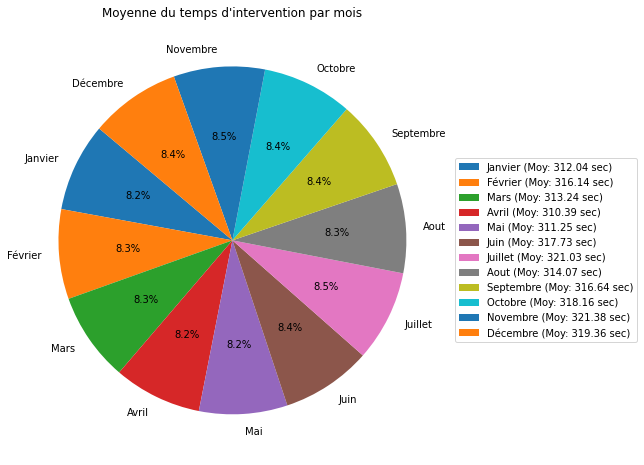

In [13]:
monthly_mean_time = LFB_Incidents_d.groupby('Mois')['FirstPumpArriving_AttendanceTime'].mean()
months = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Aout', 'Septembre', 'Octobre', 'Novembre', 'Décembre']

# Créer un Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(monthly_mean_time, labels=months, autopct='%1.1f%%', startangle=140)
plt.title('Moyenne du temps d\'intervention par mois')

#legend_labels = [f"{months[i]} (Moy: {monthly_mean_time[i]:.2f} min)" for i in range(len(months))]
legend_labels = [f"{month} (Moy: {mean:.2f} sec)" for month, mean in zip(months, monthly_mean_time)]
plt.legend(legend_labels, loc='upper left', bbox_to_anchor=(1, 0.7))
plt.show()

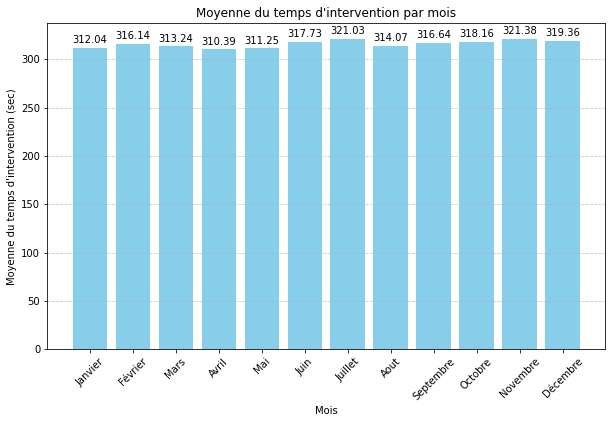

In [48]:
# 'monthly_mean_time' contient la moyenne du temps d'intervention par mois
# 'months' est une liste de noms de mois
monthly_mean_time = LFB_Incidents_d.groupby('Mois')['FirstPumpArriving_AttendanceTime'].mean()
months = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Aout', 'Septembre', 'Octobre', 'Novembre', 'Décembre']

# Espacement supplémentaire entre les barres
bar_width = 0.8

# Créer un histogramme avec des légendes au-dessus des barres
plt.figure(figsize=(10, 6))
bars = plt.bar(months, monthly_mean_time, color='skyblue', width=bar_width)  # Ajuster la largeur des barres
plt.xlabel('Mois')
plt.ylabel('Moyenne du temps d\'intervention (sec)')
plt.title('Moyenne du temps d\'intervention par mois')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajouter des légendes (annotations) au-dessus des barres
for bar, mean in zip(bars, monthly_mean_time):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{mean:.2f}', ha='center', color='black')

plt.show()


##### Test statistique 

In [49]:
# Séparer les temps d'intervention par mois en listes distinctes
monthly_data = [LFB_Incidents_d[LFB_Incidents_d['Mois'] == month]['FirstPumpArriving_AttendanceTime'] for month in range(1, 13)]

# Effectuer le test d'ANOVA
f_statistic, p_value = f_oneway(*monthly_data)

# Interprétation du résultat de l'ANOVA
if p_value < 0.05:
    print("f statistic:",f_statistic ,"p_value:",p_value )
    print("L'ANOVA montre qu'il existe une différence statistiquement significative entre les mois.")
    print("Cela signifie que le temps d'intervention varie en fonction du mois de l'année.")
else:
    print("f statistic:",f_statistic ,"p_value:",p_value )
    print("L'ANOVA n'a pas trouvé de différence statistiquement significative entre les mois.")
    print("Cela suggère que le temps d'intervention ne varie pas considérablement en fonction du mois de l'année.")

f statistic: 80.46816007306143 p_value: 1.120431674796777e-182
L'ANOVA montre qu'il existe une différence statistiquement significative entre les mois.
Cela signifie que le temps d'intervention varie en fonction du mois de l'année.


#### Par jour 

##### Représentation graphique 

In [ ]:
print(LFB_Incidents_filtre['DateOfCall'])

In [50]:
LFB_Incidents_d['Date'] = pd.to_datetime(LFB_Incidents_d['DateOfCall'])  # colonne est de type datetime

# Crée une nouvelle colonne pour le jour de la semaine
LFB_Incidents_d['Jour_de_la_semaine'] = LFB_Incidents_d['Date'].dt.day_name()
LFB_Incidents_d['Numero_jour'] = LFB_Incidents_d["Date"].dt.dayofweek
print(LFB_Incidents_d['Numero_jour'])

1          3
2          3
3          3
4          3
5          3
          ..
1602827    0
1602828    0
1602831    0
1602832    0
1602833    0
Name: Numero_jour, Length: 1287593, dtype: int32


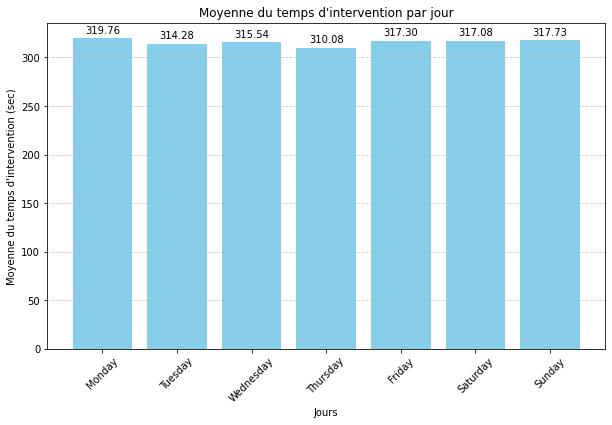

In [16]:
daily_mean_time = LFB_Incidents_d.groupby('Jour_de_la_semaine')['FirstPumpArriving_AttendanceTime'].mean()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Espacement supplémentaire entre les barres
bar_width = 0.8

# Créer un histogramme avec des légendes au-dessus des barres
plt.figure(figsize=(10, 6))
bars = plt.bar(days, daily_mean_time, color='skyblue', width=bar_width)  # Ajuster la largeur des barres
plt.xlabel('Jours')
plt.ylabel('Moyenne du temps d\'intervention (sec)')
plt.title('Moyenne du temps d\'intervention par jour')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajouter des légendes (annotations) au-dessus des barres
for bar, mean in zip(bars, daily_mean_time):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{mean:.2f}', ha='center', color='black')

plt.show()

##### Test statistique 

In [51]:
# Séparer les temps d'intervention par mois en listes distinctes
daily_data = [LFB_Incidents_d[LFB_Incidents_d['Jour_de_la_semaine'] == day]['FirstPumpArriving_AttendanceTime'] for day in days]

# Effectuer le test d'ANOVA
f_statistic, p_value = f_oneway(*daily_data)

# Interprétation du résultat de l'ANOVA
if p_value < 0.05:
    print("f statistic:",f_statistic ,"p_value:",p_value )
    print("L'ANOVA montre qu'il existe une différence statistiquement significative entre les jours.")
    print("Cela signifie que le temps d'intervention varie en fonction du jour de la semaine.")
else:
    print("f statistic:",f_statistic ,"p_value:",p_value )
    print("L'ANOVA n'a pas trouvé de différence statistiquement significative entre les jours.")
    print("Cela suggère que le temps d'intervention ne varie pas considérablement en fonction du jour de la semaine.")

NameError: name 'days' is not defined

#### Par heure

##### Représentation graphique 

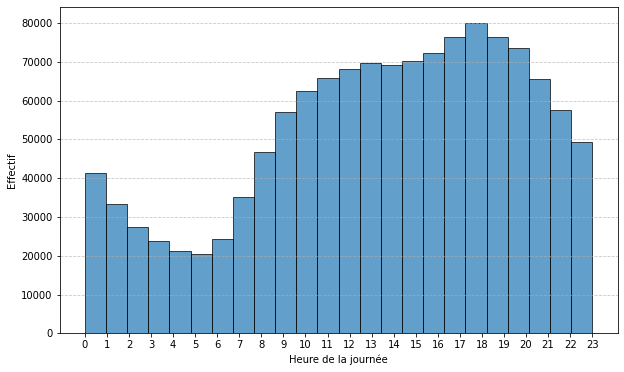

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(LFB_Incidents_d['HourOfCall'], bins=24, edgecolor='k', alpha=0.7)
plt.xlabel('Heure de la journée')
plt.ylabel('Effectif')
#plt.title('Histogramme du temps d\'intervention par heure de la journée')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##### Test statistique 

In [ ]:
# Séparer les temps d'intervention par mois en listes distinctes
hourly_data = [LFB_Incidents_d[LFB_Incidents_d['HourOfCall'] == hour]['FirstPumpArriving_AttendanceTime'] for hour in range(0, 24)]

# Effectuer le test d'ANOVA
f_statistic, p_value = f_oneway(*hourly_data)

# Interprétation du résultat de l'ANOVA
if p_value < 0.05:
    print("f statistic:",f_statistic ,"p_value:",p_value )
    print("L'ANOVA montre qu'il existe une différence statistiquement significative entre les heures.")
    print("Cela signifie que le temps d'intervention varie en fonction de l'heure de la journée")
else:
    print("f statistic:",f_statistic ,"p_value:",p_value )
    print("L'ANOVA n'a pas trouvé de différence statistiquement significative entre les heures.")
    print("Cela suggère que le temps d'intervention ne varie pas considérablement en fonction des heures de la journée.")

##### Histo horizontal par type d'incident 

In [ ]:
def plot_horizontal_histogram(data, category_variable, time_variable):
    """
    Crée un histogramme horizontal des moyennes de temps par catégorie.

    Args:
        data (pandas.DataFrame): Le DataFrame contenant les données.
        category_variable (str): Le nom de la variable catégorielle (axe des ordonnées).
        time_variable (str): Le nom de la variable de temps (axe des abscisses).

    Returns:
        None
    """
    # Calculer la moyenne du temps pour chaque catégorie
    category_means = data.groupby(category_variable)[time_variable].mean()
    category_means = category_means.sort_values(ascending=True)
    # Créer une figure et un axe
    fig, ax = plt.subplots()

    # Créer un histogramme horizontal
    ax.barh(category_means.index, category_means.values)

    # Définir les étiquettes des axes
    ax.set_xlabel(f"Temps moyen ({time_variable})")
    ax.set_ylabel(category_variable)
    ax.set_title(f"Histogramme horizontal de type d'incident par temps moyen")

    # Afficher le graphique
    plt.show()


    # Appeler la fonction pour créer l'histogramme
plot_horizontal_histogram(LFB_Incidents_d, category_variable='StopCodeDescription', time_variable='FirstPumpArriving_AttendanceTime')



#### Test de stationarité 

In [ ]:
def test_stationarity(data_frame, column_name, freq):
    # Regrouper les données par mois et calculer la moyenne mensuelle
    monthly_data = data_frame.resample('M')[column_name].mean()

    # Effectuer le test Augmented Dickey-Fuller (ADF) sur les données mensuelles
    result = adfuller(monthly_data.dropna())  # Supprimer les valeurs manquantes

    # Extraire et afficher les résultats
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]

    print(f'Résultats du test ADF pour la série {column_name} (fréquence: {freq}):')
    print(f'Statistique ADF : {adf_statistic}')
    print(f'p-value : {p_value}')
    print('Valeurs critiques :')
    for key, value in critical_values.items():
        print(f'    {key}: {value}')

    # Interprétation du test
    if p_value <= 0.05:
        print(f'La série {column_name} est stationnaire (p-value <= 0.05)')
    else:
        print(f'La série {column_name} n\'est pas stationnaire (p-value > 0.05)')

# On s'assure que l'index est basé sur la colonne 'Date'
LFB_Incidents_d.set_index('Date', inplace=True)


# Appel de la fonction pour s'assurer de la stationarité des données mensuelles 
test_stationarity(LFB_Incidents_d, 'FirstPumpArriving_AttendanceTime', 'mensuelle')


### Réduction de la base aux seules données renseignées 

In [52]:
LFB_Incidents_sub=LFB_Incidents_filtre.dropna(subset=['Latitude'])

In [ ]:
calculer_statistiques_descriptives(LFB_Incidents_sub,"C:/Users/rymat/Documents/Data London/Export", "Incidents sub" )

### Répartition géographique des interventions

In [ ]:
def create_intervention_time_map(data):
    """
    Crée une carte de Londres colorée en fonction de la durée moyenne du temps d'intervention par district.

    Args:
        data (pandas.DataFrame): Le DataFrame contenant les données de localisation, de district et de temps d'intervention.

    Returns:
        folium.Map: La carte de Londres avec les couleurs des districts en fonction du temps d'intervention moyen.
    """
    # Regrouper les données par district et calculer la durée moyenne d'intervention
    district_means = data.groupby('ProperCase')['FirstPumpArriving_AttendanceTime'].mean()

    # Créer une carte de Londres centrée sur un point arbitraire
    london_map = folium.Map(location=[51.5074, -0.1278], zoom_start=10)

    # Définir une palette de couleurs en fonction du temps d'intervention moyen
    colors = ['green', 'yellow', 'orange', 'red']
    district_colors = pd.cut(district_means, bins=[0, 180, 360, 540, float('inf')], labels=colors)

    # Ajouter les districts à la carte avec des couleurs en fonction du temps moyen
    for district, color in zip(district_means.index, district_colors):
        folium.CircleMarker(
            location=data[data['ProperCase'] == district][['Latitude', 'Longitude']].mean(),
            radius=10,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6,
            popup=f"ProperCase: {district}<br>Temps moyen d'intervention: {district_means[district]:.2f} minutes"
        ).add_to(london_map)

    # Créer une légende
    legend_html = """
    <div style="position: fixed; bottom: 50px; left: 50px; z-index:9999; font-size:14px;">
      <p><strong>Légende</strong></p>
      <p><span style="background-color: green; padding: 5px; border-radius: 50%;"></span> < 3 min</p>
      <p><span style="background-color: yellow; padding: 5px; border-radius: 50%;"></span> 3 min - 6 min</p>
      <p><span style="background-color: orange; padding: 5px; border-radius: 50%;"></span> 6 min - 9 min</p>
      <p><span style="background-color: red; padding: 5px; border-radius: 50%;"></span> > 9 min</p>
    </div>
    """
    london_map.get_root().html.add_child(folium.Element(legend_html))

    return london_map


    # Appeler la fonction pour créer la carte
    london_intervention_map = create_intervention_time_map(LFB_Incidents_sub)

    # Afficher la carte (elle peut également être sauvegardée en HTML)
    london_intervention_map.save('london_intervention_map.html')


### Création de la base de travail 

In [53]:
# Jointure des 2 tables via l'id incident

database = LFB_Incidents_d.merge(right = LFB_Mobilisations_d, on = 'IncidentNumber', how = 'inner')
database.info()
database.describe().to_csv('stats_desc_database.csv')



database_sub = LFB_Incidents_sub.merge(right = LFB_Mobilisations_d, on = 'IncidentNumber', how = 'inner')
database_sub.info()
database_sub.describe().to_csv('stats_desc_database_sub.csv')

#on resupprime les lignes manquantes car la jointure a pu rapporter des lignes avec na 
database=database.dropna(axis=0, how='any')
database_sub=database_sub.dropna(axis=0, how='any')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1792408 entries, 0 to 1792407
Data columns (total 43 columns):
 #   Column                                 Dtype         
---  ------                                 -----         
 0   IncidentNumber                         object        
 1   DateOfCall                             object        
 2   CalYear_x                              int64         
 3   TimeOfCall                             object        
 4   HourOfCall_x                           int64         
 5   IncidentGroup                          object        
 6   StopCodeDescription                    object        
 7   PropertyCategory                       object        
 8   PropertyType                           object        
 9   AddressQualifier                       object        
 10  Postcode_district                      object        
 11  IncGeo_BoroughCode                     object        
 12  ProperCase                             object        
 1

In [54]:
database = database.drop("Jour_de_la_semaine", axis=1)


### Suppression des variables redondantes ou non utiles 

In [55]:
database = database.drop(['IncidentNumber', 'TimeOfCall', 'AddressQualifier', 'Postcode_district', 
                         'IncGeo_BoroughCode', 'ResourceMobilisationId', 'Resource_Code', 'PerformanceReporting', 
                         'DateAndTimeMobilised', 'DateAndTimeMobile', 'DateAndTimeArrived', 'DateAndTimeLeft', 
                         'DeployedFromStation_Code', 'DeployedFromStation_Name', 'DeployedFromLocation', 'PlusCode_Code', 
                         'PlusCode_Description', 'PropertyType', 'FirstPumpArriving_DeployedFromStation'], axis =1)


database_sub = database_sub.drop(['IncidentNumber', 'TimeOfCall', 'AddressQualifier', 'Postcode_full', 'Postcode_district', 
                         'UPRN', 'USRN', 'IncGeo_BoroughCode', 'IncGeo_BoroughName', 'IncGeo_WardCode', 'IncGeo_WardName', 
                         'IncGeo_WardNameNew', 'Easting_m', 'Northing_m', 'Easting_rounded', 'Northing_rounded', 
                          'FRS', 'ResourceMobilisationId', 'Resource_Code', 'PerformanceReporting', 
                         'DateAndTimeMobilised', 'DateAndTimeMobile', 'DateAndTimeArrived', 'DateAndTimeLeft', 
                         'DeployedFromStation_Code', 'DeployedFromStation_Name', 'DeployedFromLocation', 'PlusCode_Code', 
                         'PlusCode_Description', 'PropertyType', 'FirstPumpArriving_DeployedFromStation',
                                  'SecondPumpArriving_DeployedFromStation','SpecialServiceType'], axis =1)

#### Dummies et encodage

In [56]:
def encode_features(data):
    """
    Fonction pour extraire et encoder le mois, l'année et le type d'intervention.

    Args:
        data (pandas.DataFrame): Le DataFrame contenant les données.

    Returns:
        pandas.DataFrame: Le DataFrame avec les caractéristiques extraites et encodées.
    """
    # Extraction du mois et de l'année de la colonne "Date"
    data['Date'] = pd.to_datetime(data['DateOfCall'])
    data['Mois'] = data['Date'].dt.month
    data['Année'] = data['Date'].dt.year

    # Encodage du type d'intervention en one-hot
    #data = pd.get_dummies(data, columns=['StopCodeDescription'], prefix=['intervention'])

    # Encodage one-hot pour le mois
    data = pd.get_dummies(data, columns=['Mois'], prefix=['mois'])

    # Encodage one-hot pour l'année
    data = pd.get_dummies(data, columns=['Année'], prefix=['année'])

    return data



    # Appel de la fonction pour encoder les caractéristiques
data_encoded = encode_features(database)
data_sub_encoded = encode_features(database_sub)

data_encoded = data_encoded.drop(['DateOfCall', 'Date'], axis=1)
data_sub_encoded = data_sub_encoded.drop(['DateOfCall','Date'], axis=1)


In [ ]:
data_encoded.info()

In [57]:
# On doit faire variable par variable car une fonction qui récupère tous les objects et les mets en dummy prend trop 
#d'espace mémoire et crash 

def add_dummy_to_dataframe(dataframe, variable_name, prefix=None):

    variable = dataframe[variable_name]
    

    if prefix is not None:
        dummies = pd.get_dummies(variable, prefix=prefix)
    else:
        dummies = pd.get_dummies(variable)
    
    dataframe = pd.concat([dataframe, dummies], axis=1)
    dataframe = dataframe.drop(variable_name, axis=1)
    return dataframe


# database
data_encoded = add_dummy_to_dataframe(data_encoded, variable_name='IncidentGroup', prefix='IncidentGroup')
data_encoded = add_dummy_to_dataframe(data_encoded, variable_name='StopCodeDescription', prefix='StopCodeDescription')
data_encoded = add_dummy_to_dataframe(data_encoded, variable_name='PropertyCategory', prefix='PropertyCategory')

data_encoded = add_dummy_to_dataframe(data_encoded, variable_name='ProperCase', prefix='ProperCase')
data_encoded = add_dummy_to_dataframe(data_encoded, variable_name='IncidentStationGround', prefix='IncidentStationGround')
#data_encoded = add_dummy_to_dataframe(data_encoded, variable_name='FirstPumpArriving_DeployedFromStation', prefix='FirstPumpArriving_DeployedFromStation')

#database_sub
data_sub_encoded = add_dummy_to_dataframe(data_sub_encoded, variable_name='IncidentGroup', prefix='IncidentGroup')
data_sub_encoded = add_dummy_to_dataframe(data_sub_encoded, variable_name='StopCodeDescription', prefix='StopCodeDescription')
data_sub_encoded = add_dummy_to_dataframe(data_sub_encoded, variable_name='PropertyCategory', prefix='PropertyCategory')


data_sub_encoded = add_dummy_to_dataframe(data_sub_encoded, variable_name='ProperCase', prefix='ProperCase')
data_sub_encoded = add_dummy_to_dataframe(data_sub_encoded, variable_name='IncidentStationGround', prefix='IncidentStationGround')
#data_sub_encoded = add_dummy_to_dataframe(data_sub_encoded, variable_name='FirstPumpArriving_DeployedFromStation', prefix='FirstPumpArriving_DeployedFromStation')


In [58]:
#on divise les tailles de la par 8 environ 


data_encoded_samp = data_encoded.sample(n=1000, random_state=42)
data_encoded_samp


features = data_encoded_samp.drop('FirstPumpArriving_AttendanceTime', axis=1)
target = data_encoded_samp['FirstPumpArriving_AttendanceTime']


In [59]:
data_encoded.to_csv('data_encoded.csv', index=False)
features.to_csv('features.csv', index=False)
target.to_csv('target.csv', index=False)

# Régresseurs 

# KNN

In [24]:
def knn_grid_search(X, y):
    """
    Effectue une recherche sur la grille des hyperparamètres pour un modèle de KNN.

    Parameters:
        - X: Les caractéristiques d'entraînement.
        - y: La variable cible.

    Returns:
        - best_params: Les meilleurs hyperparamètres trouvés.
        - best_model: Le meilleur modèle KNN entraîné.
        - mse_train: MSE sur les données d'entraînement.
        - mse_test: MSE sur les données de test.
        - mae_train: Mean Absolute Error sur les données d'entraînement.
        - mae_test: Mean Absolute Error sur les données de test.
        - r2_train: Coefficient de détermination R² sur les données d'entraînement.
        - r2_test: Coefficient de détermination R² sur les données de test.
    """
    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Paramètres à tester
    param_grid = {
        'n_neighbors': [3, 5, 7, 10],
        'leaf_size': [10, 20, 30],
        'p': [1, 2],  # 1 pour la distance de Manhattan, 2 pour la distance euclidienne
        'metric': ['euclidean', 'manhattan', 'minkowski'],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }

    # Initialiser le modèle KNN
    knn = KNeighborsRegressor()

    # Initialiser GridSearchCV
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise')

    # Exécuter la recherche sur la grille des hyperparamètres
    grid_search.fit(X_train, y_train)

    # Obtenir les meilleurs hyperparamètres
    best_params = grid_search.best_params_

    # Obtenir le meilleur modèle de régression
    best_model = grid_search.best_estimator_

    # Prédire sur l'ensemble d'entraînement
    y_train_pred = best_model.predict(X_train)

    # Prédire sur l'ensemble de test
    y_test_pred = best_model.predict(X_test)

    # Calculer les métriques pour l'ensemble d'entraînement
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    # Calculer les métriques pour l'ensemble de test
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Afficher les résultats
    print("Meilleurs hyperparamètres:", best_params)
    print("MSE sur l'ensemble d'entraînement:", mse_train)
    print("MSE sur l'ensemble de test:", mse_test)
    print("Mean Absolute Error sur l'ensemble d'entraînement:", mae_train)
    print("Mean Absolute Error sur l'ensemble de test:", mae_test)
    print("R² sur l'ensemble d'entraînement:", r2_train)
    print("R² sur l'ensemble de test:", r2_test)

    return best_params, best_model, mse_train, mse_test, mae_train, mae_test, r2_train, r2_test


knn_grid_search(features, target)

Meilleurs hyperparamètres: {'algorithm': 'ball_tree', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
MSE sur l'ensemble d'entraînement: 5010.1172750000005
MSE sur l'ensemble de test: 10120.5571
Mean Absolute Error sur l'ensemble d'entraînement: 37.5425
Mean Absolute Error sur l'ensemble de test: 51.401
R² sur l'ensemble d'entraînement: 0.658942204250096
R² sur l'ensemble de test: 0.5189110824730017


({'algorithm': 'ball_tree',
  'leaf_size': 20,
  'metric': 'manhattan',
  'n_neighbors': 10,
  'p': 1,
  'weights': 'uniform'},
 KNeighborsRegressor(algorithm='ball_tree', leaf_size=20, metric='manhattan',
                     n_neighbors=10, p=1),
 5010.1172750000005,
 10120.5571,
 37.5425,
 51.401,
 0.658942204250096,
 0.5189110824730017)

# Regression linéaire 

In [28]:
def linear_regression_grid_search(X, y):
    """
    Effectue une recherche sur la grille des hyperparamètres pour un modèle de KNN.

    Parameters:
        - X: Les caractéristiques d'entraînement.
        - y: La variable cible.

    Returns:
        - best_params: Les meilleurs hyperparamètres trouvés.
        - best_model: Le meilleur modèle KNN entraîné.
        - mse_train: MSE sur les données d'entraînement.
        - mse_test: MSE sur les données de test.
        - mae_train: Mean Absolute Error sur les données d'entraînement.
        - mae_test: Mean Absolute Error sur les données de test.
        - r2_train: Coefficient de détermination R² sur les données d'entraînement.
        - r2_test: Coefficient de détermination R² sur les données de test.
    """
    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Paramètres à tester
    param_grid = {
        'fit_intercept': [True, False],
        'copy_X': [True, False],
        'n_jobs': [None, -1],
        'positive': [False, True]
    }

    # Initialiser le modèle de régression linéaire
    linear_reg = LinearRegression()

    # Initialiser GridSearchCV
    grid_search = GridSearchCV(linear_reg, param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise')

    # Exécuter la recherche sur la grille des hyperparamètres
    grid_search.fit(X_train, y_train)

    # Obtenir les meilleurs hyperparamètres
    best_params = grid_search.best_params_

    # Obtenir le meilleur modèle de régression 
    best_model = grid_search.best_estimator_

    # Prédire sur l'ensemble d'entraînement
    y_train_pred = best_model.predict(X_train)

    # Prédire sur l'ensemble de test
    y_test_pred = best_model.predict(X_test)

    # Calculer les métriques pour l'ensemble d'entraînement
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    # Calculer les métriques pour l'ensemble de test
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Afficher les résultats
    print("Meilleurs hyperparamètres:", best_params)
    print("MSE sur l'ensemble d'entraînement:", mse_train)
    print("MSE sur l'ensemble de test:", mse_test)
    print("Mean Absolute Error sur l'ensemble d'entraînement:", mae_train)
    print("Mean Absolute Error sur l'ensemble de test:", mae_test)
    print("R² sur l'ensemble d'entraînement:", r2_train)
    print("R² sur l'ensemble de test:", r2_test)

    return best_params, best_model, mse_train, mse_test, mae_train, mae_test, r2_train, r2_test


linear_regression_grid_search(features, target)


Meilleurs hyperparamètres: {'copy_X': True, 'fit_intercept': False, 'n_jobs': None, 'positive': True}
MSE sur l'ensemble d'entraînement: 4395.940754180563
MSE sur l'ensemble de test: 10026.675409922656
Mean Absolute Error sur l'ensemble d'entraînement: 43.443149390558595
Mean Absolute Error sur l'ensemble de test: 60.55142845444935
R² sur l'ensemble d'entraînement: 0.7007515430129341
R² sur l'ensemble de test: 0.5233738250086784


({'copy_X': True, 'fit_intercept': False, 'n_jobs': None, 'positive': True},
 LinearRegression(fit_intercept=False, positive=True),
 4395.940754180563,
 10026.675409922656,
 43.443149390558595,
 60.55142845444935,
 0.7007515430129341,
 0.5233738250086784)

# Ridge 

In [29]:
def ridge_regression_grid_search(X, y):
    """
    Effectue une recherche sur la grille des hyperparamètres pour un modèle de KNN.

    Parameters:
        - X: Les caractéristiques d'entraînement.
        - y: La variable cible.

    Returns:
        - best_params: Les meilleurs hyperparamètres trouvés.
        - best_model: Le meilleur modèle KNN entraîné.
        - mse_train: MSE sur les données d'entraînement.
        - mse_test: MSE sur les données de test.
        - mae_train: Mean Absolute Error sur les données d'entraînement.
        - mae_test: Mean Absolute Error sur les données de test.
        - r2_train: Coefficient de détermination R² sur les données d'entraînement.
        - r2_test: Coefficient de détermination R² sur les données de test.
    """
    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Paramètres à tester
    param_grid = {
        'alpha': [0.1, 1.0, 10.0],
        'fit_intercept': [True, False],
        'copy_X': [True, False],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    }

    # Initialiser le modèle de régression Ridge
    ridge_reg = Ridge()

    # Initialiser GridSearchCV
    grid_search = GridSearchCV(ridge_reg, param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise')

    # Exécuter la recherche sur la grille des hyperparamètres
    grid_search.fit(X_train, y_train)

    # Obtenir les meilleurs hyperparamètres
    best_params = grid_search.best_params_

    # Obtenir le meilleur modèle de régression 
    best_model = grid_search.best_estimator_

    # Prédire sur l'ensemble d'entraînement
    y_train_pred = best_model.predict(X_train)

    # Prédire sur l'ensemble de test
    y_test_pred = best_model.predict(X_test)

    # Calculer les métriques pour l'ensemble d'entraînement
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    # Calculer les métriques pour l'ensemble de test
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Afficher les résultats
    print("Meilleurs hyperparamètres:", best_params)
    print("MSE sur l'ensemble d'entraînement:", mse_train)
    print("MSE sur l'ensemble de test:", mse_test)
    print("Mean Absolute Error sur l'ensemble d'entraînement:", mae_train)
    print("Mean Absolute Error sur l'ensemble de test:", mae_test)
    print("R² sur l'ensemble d'entraînement:", r2_train)
    print("R² sur l'ensemble de test:", r2_test)

    return best_params, best_model, mse_train, mse_test, mae_train, mae_test, r2_train, r2_test


ridge_regression_grid_search(features, target)


C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rymat\

C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rymat\

C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rymat\

Meilleurs hyperparamètres: {'alpha': 10.0, 'copy_X': True, 'fit_intercept': True, 'solver': 'lsqr'}
MSE sur l'ensemble d'entraînement: 3630.2813557187783
MSE sur l'ensemble de test: 7312.702592782032
Mean Absolute Error sur l'ensemble d'entraînement: 37.29152690330738
Mean Absolute Error sur l'ensemble de test: 44.82420693991744
R² sur l'ensemble d'entraînement: 0.7528728991411844
R² sur l'ensemble de test: 0.652384731413809


C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


({'alpha': 10.0, 'copy_X': True, 'fit_intercept': True, 'solver': 'lsqr'},
 Ridge(alpha=10.0, solver='lsqr'),
 3630.2813557187783,
 7312.702592782032,
 37.29152690330738,
 44.82420693991744,
 0.7528728991411844,
 0.652384731413809)

# Lasso

In [31]:
def lasso_regression_grid_search(X, y):
    """
    Effectue une recherche sur la grille des hyperparamètres pour un modèle de KNN.

    Parameters:
        - X: Les caractéristiques d'entraînement.
        - y: La variable cible.

    Returns:
        - best_params: Les meilleurs hyperparamètres trouvés.
        - best_model: Le meilleur modèle KNN entraîné.
        - mse_train: MSE sur les données d'entraînement.
        - mse_test: MSE sur les données de test.
        - mae_train: Mean Absolute Error sur les données d'entraînement.
        - mae_test: Mean Absolute Error sur les données de test.
        - r2_train: Coefficient de détermination R² sur les données d'entraînement.
        - r2_test: Coefficient de détermination R² sur les données de test.
    """
    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Paramètres à tester
    param_grid = {
        'alpha': [0.1, 1.0, 10.0],
        'fit_intercept': [True, False],
        'copy_X': [True, False],
        'max_iter': [1000, 2000, 5000],
        'selection': ['cyclic', 'random']
    }

    # Initialiser le modèle de régression Lasso
    lasso_reg = Lasso()

    # Initialiser GridSearchCV
    grid_search = GridSearchCV(lasso_reg, param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise')

    # Exécuter la recherche sur la grille des hyperparamètres
    grid_search.fit(X_train, y_train)

   # Obtenir les meilleurs hyperparamètres
    best_params = grid_search.best_params_

    # Obtenir le meilleur modèle de régression 
    best_model = grid_search.best_estimator_

    # Prédire sur l'ensemble d'entraînement
    y_train_pred = best_model.predict(X_train)

    # Prédire sur l'ensemble de test
    y_test_pred = best_model.predict(X_test)

    # Calculer les métriques pour l'ensemble d'entraînement
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    # Calculer les métriques pour l'ensemble de test
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Afficher les résultats
    print("Meilleurs hyperparamètres:", best_params)
    print("MSE sur l'ensemble d'entraînement:", mse_train)
    print("MSE sur l'ensemble de test:", mse_test)
    print("Mean Absolute Error sur l'ensemble d'entraînement:", mae_train)
    print("Mean Absolute Error sur l'ensemble de test:", mae_test)
    print("R² sur l'ensemble d'entraînement:", r2_train)
    print("R² sur l'ensemble de test:", r2_test)

    return best_params, best_model, mse_train, mse_test, mae_train, mae_test, r2_train, r2_test


lasso_regression_grid_search(features, target)


C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.776e+05, tolerance: 8.836e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.968e+05, tolerance: 6.869e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.404e+05, tolerance: 7.182e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.619e+05, tolerance: 6.975e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.158e+06, tolerance: 6.893e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.045e+05, tolerance: 6.869e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.307e+05, tolerance: 7.182e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.937e+05, tolerance: 6.975e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.799e+05, tolerance: 7.182e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.568e+03, tolerance: 9.506e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

C:\Users\rymat\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.790e+05, tolerance: 6.991e+03
  model = cd_fast.enet_coordinate_descent(


Meilleurs hyperparamètres: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': False, 'max_iter': 5000, 'selection': 'random'}
MSE sur l'ensemble d'entraînement: 4037.58293579623
MSE sur l'ensemble de test: 7274.105370959274
Mean Absolute Error sur l'ensemble d'entraînement: 37.06906566281347
Mean Absolute Error sur l'ensemble de test: 42.84877652092304
R² sur l'ensemble d'entraînement: 0.7251463267913048
R² sur l'ensemble de test: 0.654219481762311


({'alpha': 1.0,
  'copy_X': True,
  'fit_intercept': False,
  'max_iter': 5000,
  'selection': 'random'},
 Lasso(fit_intercept=False, max_iter=5000, selection='random'),
 4037.58293579623,
 7274.105370959274,
 37.06906566281347,
 42.84877652092304,
 0.7251463267913048,
 0.654219481762311)

# random forest 

In [33]:
def random_forest_grid_search(X, y):
    """
    Effectue une recherche sur la grille des hyperparamètres pour un modèle de KNN.

    Parameters:
        - X: Les caractéristiques d'entraînement.
        - y: La variable cible.

    Returns:
        - best_params: Les meilleurs hyperparamètres trouvés.
        - best_model: Le meilleur modèle KNN entraîné.
        - mse_train: MSE sur les données d'entraînement.
        - mse_test: MSE sur les données de test.
        - mae_train: Mean Absolute Error sur les données d'entraînement.
        - mae_test: Mean Absolute Error sur les données de test.
        - r2_train: Coefficient de détermination R² sur les données d'entraînement.
        - r2_test: Coefficient de détermination R² sur les données de test.
    """
    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Paramètres à tester
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    }

    # Initialiser le modèle de régression Random Forest
    random_forest = RandomForestRegressor()

    # Initialiser GridSearchCV
    grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise')

    # Exécuter la recherche sur la grille des hyperparamètres
    grid_search.fit(X_train, y_train)

    # Obtenir les meilleurs hyperparamètres
    best_params = grid_search.best_params_

    # Obtenir le meilleur modèle de régression
    best_model = grid_search.best_estimator_

    # Prédire sur l'ensemble d'entraînement
    y_train_pred = best_model.predict(X_train)

    # Prédire sur l'ensemble de test
    y_test_pred = best_model.predict(X_test)

    # Calculer les métriques pour l'ensemble d'entraînement
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    # Calculer les métriques pour l'ensemble de test
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Afficher les résultats
    print("Meilleurs hyperparamètres:", best_params)
    print("MSE sur l'ensemble d'entraînement:", mse_train)
    print("MSE sur l'ensemble de test:", mse_test)
    print("Mean Absolute Error sur l'ensemble d'entraînement:", mae_train)
    print("Mean Absolute Error sur l'ensemble de test:", mae_test)
    print("R² sur l'ensemble d'entraînement:", r2_train)
    print("R² sur l'ensemble de test:", r2_test)

    return best_params, best_model, mse_train, mse_test, mae_train, mae_test, r2_train, r2_test


random_forest_grid_search(features, target)

Meilleurs hyperparamètres: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
MSE sur l'ensemble d'entraînement: 0.0028764999999999334
MSE sur l'ensemble de test: 8211.403752999999
Mean Absolute Error sur l'ensemble d'entraînement: 0.011962499999999423
Mean Absolute Error sur l'ensemble de test: 49.79365
R² sur l'ensemble d'entraînement: 0.9999998041856716
R² sur l'ensemble de test: 0.6096642404292248


({'bootstrap': False,
  'max_depth': None,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 200},
 RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=200),
 0.0028764999999999334,
 8211.403752999999,
 0.011962499999999423,
 49.79365,
 0.9999998041856716,
 0.6096642404292248)

# decision tree 

In [35]:
def decision_tree_grid_search(X, y):
    """
    Effectue une recherche sur la grille des hyperparamètres pour un modèle de KNN.

    Parameters:
        - X: Les caractéristiques d'entraînement.
        - y: La variable cible.

    Returns:
        - best_params: Les meilleurs hyperparamètres trouvés.
        - best_model: Le meilleur modèle KNN entraîné.
        - mse_train: MSE sur les données d'entraînement.
        - mse_test: MSE sur les données de test.
        - mae_train: Mean Absolute Error sur les données d'entraînement.
        - mae_test: Mean Absolute Error sur les données de test.
        - r2_train: Coefficient de détermination R² sur les données d'entraînement.
        - r2_test: Coefficient de détermination R² sur les données de test.
    """
    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Paramètres à tester
    param_grid = {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }

    # Initialiser le modèle de régression Decision Tree
    decision_tree = DecisionTreeRegressor()

    # Initialiser GridSearchCV
    grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise')

    # Exécuter la recherche sur la grille des hyperparamètres
    grid_search.fit(X_train, y_train)

    # Obtenir les meilleurs hyperparamètres
    best_params = grid_search.best_params_

    # Obtenir le meilleur modèle de régression
    best_model = grid_search.best_estimator_

    # Prédire sur l'ensemble d'entraînement
    y_train_pred = best_model.predict(X_train)

    # Prédire sur l'ensemble de test
    y_test_pred = best_model.predict(X_test)

    # Calculer les métriques pour l'ensemble d'entraînement
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    # Calculer les métriques pour l'ensemble de test
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Afficher les résultats
    print("Meilleurs hyperparamètres:", best_params)
    print("MSE sur l'ensemble d'entraînement:", mse_train)
    print("MSE sur l'ensemble de test:", mse_test)
    print("Mean Absolute Error sur l'ensemble d'entraînement:", mae_train)
    print("Mean Absolute Error sur l'ensemble de test:", mae_test)
    print("R² sur l'ensemble d'entraînement:", r2_train)
    print("R² sur l'ensemble de test:", r2_test)

    return best_params, best_model, mse_train, mse_test, mae_train, mae_test, r2_train, r2_test

decision_tree_grid_search(features, target)

Meilleurs hyperparamètres: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2}
MSE sur l'ensemble d'entraînement: 5519.916689019296
MSE sur l'ensemble de test: 12775.107430203147
Mean Absolute Error sur l'ensemble d'entraînement: 49.560685315157116
Mean Absolute Error sur l'ensemble de test: 67.21969164018032
R² sur l'ensemble d'entraînement: 0.6242382133300404
R² sur l'ensemble de test: 0.3927248723405211


({'max_depth': None,
  'max_features': 'sqrt',
  'min_samples_leaf': 4,
  'min_samples_split': 2},
 DecisionTreeRegressor(max_features='sqrt', min_samples_leaf=4),
 5519.916689019296,
 12775.107430203147,
 49.560685315157116,
 67.21969164018032,
 0.6242382133300404,
 0.3927248723405211)

# svm (tourne trop longtemps sur 1000 lignes => impossible)

In [50]:
def svm_grid_search(X, y):
   """
    Effectue une recherche sur la grille des hyperparamètres pour un modèle de KNN.

    Parameters:
        - X: Les caractéristiques d'entraînement.
        - y: La variable cible.

    Returns:
        - best_params: Les meilleurs hyperparamètres trouvés.
        - best_model: Le meilleur modèle KNN entraîné.
        - mse_train: MSE sur les données d'entraînement.
        - mse_test: MSE sur les données de test.
        - mae_train: Mean Absolute Error sur les données d'entraînement.
        - mae_test: Mean Absolute Error sur les données de test.
        - r2_train: Coefficient de détermination R² sur les données d'entraînement.
        - r2_test: Coefficient de détermination R² sur les données de test.
    """
    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Paramètres à tester
    param_grid = {
        'C': [0.1, 1.0, 10.0],
        'epsilon': [0.1, 0.2, 0.5],
        'kernel': ['linear'],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto']
    }

    # Initialiser le modèle de régression SVM
    svm_reg = SVR()

    # Initialiser GridSearchCV
    grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise')

    # Exécuter la recherche sur la grille des hyperparamètres
    grid_search.fit(X_train, y_train)

    # Obtenir les meilleurs hyperparamètres
    best_params = grid_search.best_params_

    # Obtenir le meilleur modèle de régression 
    best_model = grid_search.best_estimator_

    # Prédire sur l'ensemble d'entraînement
    y_train_pred = best_model.predict(X_train)

    # Prédire sur l'ensemble de test
    y_test_pred = best_model.predict(X_test)

    # Calculer les métriques pour l'ensemble d'entraînement
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    # Calculer les métriques pour l'ensemble de test
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Afficher les résultats
    print("Meilleurs hyperparamètres:", best_params)
    print("MSE sur l'ensemble d'entraînement:", mse_train)
    print("MSE sur l'ensemble de test:", mse_test)
    print("Mean Absolute Error sur l'ensemble d'entraînement:", mae_train)
    print("Mean Absolute Error sur l'ensemble de test:", mae_test)
    print("R² sur l'ensemble d'entraînement:", r2_train)
    print("R² sur l'ensemble de test:", r2_test)

    return best_params, best_model, mse_train, mse_test, mae_train, mae_test, r2_train, r2_test

svm_grid_search(features, target)

KeyboardInterrupt: 

# GBR

In [37]:
def gradient_boosting_grid_search(X, y):
    """
    Effectue une recherche sur la grille des hyperparamètres pour un modèle de KNN.

    Parameters:
        - X: Les caractéristiques d'entraînement.
        - y: La variable cible.

    Returns:
        - best_params: Les meilleurs hyperparamètres trouvés.
        - best_model: Le meilleur modèle KNN entraîné.
        - mse_train: MSE sur les données d'entraînement.
        - mse_test: MSE sur les données de test.
        - mae_train: Mean Absolute Error sur les données d'entraînement.
        - mae_test: Mean Absolute Error sur les données de test.
        - r2_train: Coefficient de détermination R² sur les données d'entraînement.
        - r2_test: Coefficient de détermination R² sur les données de test.
    """
    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Paramètres à tester
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.8, 1.0],
        'max_features': ['sqrt', 'log2']
    }

    # Initialiser le modèle de régression Gradient Boosting
    gradient_boosting = GradientBoostingRegressor()

    # Initialiser GridSearchCV
    grid_search = GridSearchCV(gradient_boosting, param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise')

    # Exécuter la recherche sur la grille des hyperparamètres
    grid_search.fit(X_train, y_train)

    # Obtenir les meilleurs hyperparamètres
    best_params = grid_search.best_params_

    # Obtenir le meilleur modèle de régression 
    best_model = grid_search.best_estimator_

    # Prédire sur l'ensemble d'entraînement
    y_train_pred = best_model.predict(X_train)

    # Prédire sur l'ensemble de test
    y_test_pred = best_model.predict(X_test)

    # Calculer les métriques pour l'ensemble d'entraînement
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    # Calculer les métriques pour l'ensemble de test
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Afficher les résultats
    print("Meilleurs hyperparamètres:", best_params)
    print("MSE sur l'ensemble d'entraînement:", mse_train)
    print("MSE sur l'ensemble de test:", mse_test)
    print("Mean Absolute Error sur l'ensemble d'entraînement:", mae_train)
    print("Mean Absolute Error sur l'ensemble de test:", mae_test)
    print("R² sur l'ensemble d'entraînement:", r2_train)
    print("R² sur l'ensemble de test:", r2_test)

    return best_params, best_model, mse_train, mse_test, mae_train, mae_test, r2_train, r2_test


gradient_boosting_grid_search(features, target)

Meilleurs hyperparamètres: {'learning_rate': 0.2, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 1.0}
MSE sur l'ensemble d'entraînement: 475.4945839380486
MSE sur l'ensemble de test: 5586.085910713204
Mean Absolute Error sur l'ensemble d'entraînement: 14.710649705118254
Mean Absolute Error sur l'ensemble de test: 41.11574680153049
R² sur l'ensemble d'entraînement: 0.9676312697313201
R² sur l'ensemble de test: 0.7344608604601587


({'learning_rate': 0.2,
  'max_depth': 4,
  'max_features': 'sqrt',
  'min_samples_leaf': 4,
  'min_samples_split': 5,
  'n_estimators': 200,
  'subsample': 1.0},
 GradientBoostingRegressor(learning_rate=0.2, max_depth=4, max_features='sqrt',
                           min_samples_leaf=4, min_samples_split=5,
                           n_estimators=200),
 475.4945839380486,
 5586.085910713204,
 14.710649705118254,
 41.11574680153049,
 0.9676312697313201,
 0.7344608604601587)

In [ ]:
def plot_serie_temporelle_date(dataframe, date_col, value_col):
    """
    Crée un graphique de série temporelle pour représenter les valeurs au fil du temps en utilisant la date.

    Args:
    - dataframe (pandas.DataFrame): Le dataframe contenant les données.
    - date_col (str): Le nom de la colonne contenant la date.
    - value_col (str): Le nom de la colonne contenant les valeurs à représenter.

    Returns:
    - None (affiche le graphique).
    """

    # Assurez-vous que la colonne de date est de type datetime
    dataframe[date_col] = pd.to_datetime(dataframe[date_col])

    # Trie le dataframe par date
    dataframe = dataframe.sort_values(date_col)

    # Crée le graphique de série temporelle
    plt.figure(figsize=(20, 10))
    plt.plot(dataframe[date_col], dataframe[value_col], marker='o', linestyle='-')
    plt.title('Série Temporelle des Valeurs')
    plt.xlabel('Date')
    plt.ylabel(value_col)
    plt.grid(True)
    plt.xticks(rotation=45)

    # Affiche le graphique
    plt.show()



plot_serie_temporelle_date(data_encoded, 'Date', 'FirstPumpArriving_AttendanceTime')


In [ ]:
data_encoded['Date']

In [ ]:
data_encoded.isnull().sum(axis=0)

In [ ]:
var= seasonal_decompose(data_encoded)
var.plot()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

def analyser_tendance_serie_temporelle_date(dataframe, date_col, value_col):
    """
    Analyse la tendance temporelle d'une série temporelle en utilisant uniquement la date.

    Args:
    - dataframe (pandas.DataFrame): Le dataframe contenant les données.
    - date_col (str): Le nom de la colonne contenant la date.
    - value_col (str): Le nom de la colonne contenant les valeurs de la série temporelle.

    Returns:
    - Graphique de la série temporelle décomposée montrant la tendance.
    """

    # Assurez-vous que la colonne de date est de type datetime


    # Définissez la colonne de date comme index
    dataframe.set_index(date_col)


    # Décomposition de la série temporelle
    decomposition = seasonal_decompose(dataframe[value_col], model='additive')

    # Crée un graphique de la tendance
    plt.figure(figsize=(12, 6))
    #plt.plot(decomposition.trend, label='Tendance')
    plt.title('Tendance Temporelle de la Série Temporelle')
    plt.xlabel('Date')
    plt.ylabel('Tendance')
    plt.grid(True)
    plt.legend()
    plt.show()


analyser_tendance_serie_temporelle_date(data_encoded, 'Date', 'FirstPumpArriving_AttendanceTime')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def seasonal_decompose_custom(dataframe, date_col, value_col, freq):
    """
    Effectue une décomposition saisonnière personnalisée de la série temporelle.

    Args:
    - dataframe (pandas.DataFrame): Le dataframe contenant les données.
    - date_col (str): Le nom de la colonne contenant la date.
    - value_col (str): Le nom de la colonne contenant les valeurs de la série temporelle.
    - freq (int): Fréquence saisonnière (par exemple, 7 pour une semaine).

    Returns:
    - Graphiques des composantes saisonnières, de tendance et résiduelles.
    """

    # Assurez-vous que la colonne de date est de type datetime
    dataframe[date_col] = pd.to_datetime(dataframe[date_col])

    # Définissez la colonne de date comme index
    dataframe.set_index(date_col, inplace=True)

    # Triez les données par date si ce n'est pas déjà fait
    dataframe.sort_index(inplace=True)

    # Calculez la moyenne mobile centrée pour la tendance
    dataframe['Tendance'] = dataframe[value_col].rolling(window=freq, center=True).mean()

    # Calculez les composantes saisonnières
    dataframe['Saison'] = dataframe[value_col] - dataframe['Tendance']

    # Calculez les résidus
    dataframe['Residus'] = dataframe[value_col] - dataframe['Tendance'] - dataframe['Saison']

    # Créez des graphiques des composantes saisonnières, de tendance et résiduelles
    plt.figure(figsize=(12, 10))
    plt.subplot(411)
    plt.plot(dataframe[value_col], label='Série Temporelle')
    plt.ylabel('Série Temporelle')
    plt.legend()

    plt.subplot(412)
    plt.plot(dataframe['Tendance'], label='Tendance')
    plt.ylabel('Tendance')
    plt.legend()

    plt.subplot(413)
    plt.plot(dataframe['Saison'], label='Saison')
    plt.ylabel('Saison')
    plt.legend()

    plt.subplot(414)
    plt.plot(dataframe['Residus'], label='Residus')
    plt.xlabel('Date')
    plt.ylabel('Residus')
    plt.legend()

    plt.show()


seasonal_decompose_custom(data_encoded, 'Date', 'FirstPumpArriving_AttendanceTime', freq=12)

"""
Dans une décomposition additive, la série temporelle est modélisée comme la somme de trois composantes : tendance, saison 
et résidus. C'est ce que fait cette fonction. Elle calcule la tendance en utilisant une moyenne mobile centrée, extrait 
la composante saisonnière en soustrayant la tendance de la série d'origine, et calcule les résidus en soustrayant à la 
fois la tendance et la composante saisonnière de la série d'origine.

Cette approche est adaptée aux séries temporelles dont les variations saisonnières sont additives, 
c'est-à-dire que les variations saisonnières sont relativement constantes d'une période à l'autre, 
indépendamment de l'amplitude de la série.
"""

In [ ]:

def analyse_autocorrelation(dataframe, value_col, max_lag=10):
    """
    Analyse l'autocorrélation d'une série temporelle.

    Args:
    - dataframe (pandas.DataFrame): Le dataframe contenant les données.
    - value_col (str): Le nom de la colonne contenant les valeurs de la série temporelle.
    - max_lag (int): Le nombre maximal de retards (lags) à considérer.

    Returns:
    - Graphique de l'autocorrélation.
    """

    # Calculez l'autocorrélation
    autocorr = dataframe[value_col].autocorr(lag=max_lag)

    # Créez un graphique de l'autocorrélation
    plt.figure(figsize=(12, 6))
    pd.plotting.autocorrelation_plot(dataframe[value_col])
    plt.title('Autocorrélation de la Série Temporelle')
    plt.xlabel('Lag (Retard)')
    plt.ylabel('Autocorrélation')
    plt.grid(True)
    plt.show()

    # Affichez la valeur d'autocorrélation au délai spécifié
    print(f'Autocorrélation au lag {max_lag}: {autocorr}')


analyse_autocorrelation(data_encoded, 'FirstPumpArriving_AttendanceTime', max_lag=10)
#seasonal_decompose_custom(data_encoded, 'Date', 'FirstPumpArriving_AttendanceTime', freq=12)

### Modélisation 

#### Régression linéaire 

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
import scipy.stats as stats


# Assurez-vous d'avoir les résidus du modèle
residuals = y - y_pred

# Créez un modèle supplémentaire avec les carrés des valeurs prédites
X_squared = sm.add_constant(model.predict(X))
X_squared['X^2'] = X_squared['X'] ** 2

# test RESET
reset_test = linear_reset(model, X_squared)
F_statistic = reset_test.fvalue
p_value = reset_test.pvalue

# Comparer la statistique F à une distribution F
degrees_of_freedom_numerator = len(X_squared.columns) - 1
degrees_of_freedom_denominator = len(X_squared) - degrees_of_freedom_numerator - 1
F_critical = stats.f.ppf(1 - 0.05, degrees_of_freedom_numerator, degrees_of_freedom_denominator)  # Valeur critique pour alpha = 0.05

# Interprétation du test
if F_statistic > F_critical:
    print("Le test RESET suggère des signes significatifs de non-linéarité (rejeter l'hypothèse de linéarité).")
else:
    print("Le test RESET ne suggère pas de signes significatifs de non-linéarité (ne pas rejeter l'hypothèse de linéarité).")

# Afficher la statistique F et la valeur p
print(f"Statistique F du test RESET : {F_statistic}")
print(f"Valeur p : {p_value}")


In [ ]:
import statsmodels.api as sm
import numpy as np



X = data_encoded.drop('FirstPumpArriving_AttendanceTime', axis=1)
y = data_encoded['FirstPumpArriving_AttendanceTime']

X = sm.add_constant(X)  # Ajoutez une constante pour l'intercept

# modèle de régression linéaire
model = sm.OLS(y, X).fit()

# Effectuez un test F pour évaluer la signification globale du modèle
F_statistic = model.fvalue
p_value = model.f_pvalue

# Valeur critique pour alpha = 0.05 et le nombre de degrés de liberté du modèle
degrees_of_freedom_model = len(X.columns) - 1
degrees_of_freedom_resid = len(y) - degrees_of_freedom_model - 1
F_critical = stats.f.ppf(1 - 0.05, degrees_of_freedom_model, degrees_of_freedom_resid)

# Interprétation du test
if F_statistic > F_critical:
    print("Le modèle suit une régression linéaire (signification globale du modèle).")
else:
    print("Le modèle ne suit pas une régression linéaire (non significatif globalement).")

# Afficher la statistique F et la valeur p
print(f"Statistique F : {F_statistic}")
print(f"Valeur p : {p_value}")


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt



X = data_encoded.drop('FirstPumpArriving_AttendanceTime', axis=1)
y = data_encoded['FirstPumpArriving_AttendanceTime']
# Graphiques de dispersion partiels pour chaque variable explicative
for variable_explicative in X.columns:
    sns.scatterplot(x=variable_explicative, y=y, data=data_encoded)
    plt.title(f"Graphique de dispersion partiel pour {variable_explicative}")
    plt.show()


In [ ]:
import scipy.stats as stats
import statsmodels.api as sm
import pylab

# Graphique Q-Q plot des résidus
sm.qqplot(residuals, line='s')
pylab.show()


In [ ]:
# Étape 5 : Diviser les données en ensembles d'apprentissage et de test

import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def perform_linear_regression(df, target_column, cv=5):
    # Séparer les données en caractéristiques (X) et variable cible (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Division en un ensemble d'entraînement et un ensemble de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modèle de régression linéaire sur l'ensemble d'entraînement
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Prédisez les valeurs sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Calcul du RMSE sur l'ensemble de test
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Calcul du R² sur l'ensemble de test
    r2 = r2_score(y_test, y_pred)



    return rmse, r2

rmse, r2, r2_cv = perform_linear_regression(data_encoded, target_column='FirstPumpArriving_AttendanceTime')
print('Résultats base option 1')
print(f"RMSE : {rmse}")
print(f"R² : {r2}")


rmse, r2, r2_cv = perform_linear_regression(data_sub_encoded, target_column='FirstPumpArriving_AttendanceTime')
print('Résultats base option 2')
print(f"RMSE : {rmse}")
print(f"R² : {r2}")





In [ ]:
data_sub_encoded.info()

In [ ]:
masque = data_sub_encoded.eq('False Alarm').any(axis=1)

# Indice de la première ligne correspondante
indice_ligne = data_sub_encoded.index[masque][0]

# Affichage la ligne correspondante en utilisant iloc
ligne_correspondante = data_sub_encoded.iloc[indice_ligne]

print(ligne_correspondante)

In [ ]:
lignes_dupliquees = data_encoded[data_encoded.duplicated(keep=False)]

print(lignes_dupliquees)

In [ ]:
def t_test(dataframe, variable1, variable2):
    """
    Effectue un test de Student (t-test) pour comparer les moyennes de deux variables d'un dataframe.

    Args:
        dataframe (pd.DataFrame): Le dataframe contenant les données.
        variable1 (str): Le nom de la première variable à comparer.
        variable2 (str): Le nom de la deuxième variable à comparer.

    Returns:
        dict: Un dictionnaire contenant les résultats du test.
    """
    # Sélection des échantillons pour les deux variables
    sample1 = dataframe[variable1].dropna()  # Supprimer les valeurs manquantes
    sample2 = dataframe[variable2].dropna()  # Supprimer les valeurs manquantes

    # Effectuer le test de Student
    t_statistic, p_value = stats.ttest_ind(sample1, sample2)
    p_value = "{:.{decimals}f}".format(p_value, decimals=4)
    # Dictionnaire pour stocker les résultats
    results = {
        "Moyenne FP": variable1,
        "Moyenne AT": variable2,
        "T-Statistic": t_statistic,
        "P-Value": p_value
    }

    return results


resultats_test = t_test(database, "FirstPumpArriving_AttendanceTime", "TravelTimeSeconds")
print(resultats_test)


In [ ]:
def creer_matrice_dispersion(dataframe, chemin_export_images):
    """
    Crée une image de la matrice de dispersion pour les variables numériques d'un DataFrame
    et exporte l'image.

    Args:
        dataframe (pd.DataFrame): Le DataFrame contenant les données.
        chemin_export_images (str): Le chemin où enregistrer l'image.

    Returns:
        None
    """
    variables_numeriques = dataframe.select_dtypes(include=['number'])
    pd.plotting.scatter_matrix(variables_numeriques, figsize=(14, 14), diagonal='hist')
    plt.suptitle("Matrice de Dispersion")
    nom_fichier_png = 'matrice_dispersion_scatter.png'
    chemin_fichier_png = f'{chemin_export_images}/{nom_fichier_png}'
    plt.savefig(chemin_fichier_png, format='png')
    plt.close()

creer_matrice_dispersion(LFB_Incidents_filtre, "C:/Users/rymat/Documents/Data London/Export/Incidents/Quanti" )
creer_matrice_dispersion(LFB_Mobilisations, "C:/Users/rymat/Documents/Data London/Export/Mobilisations/Quanti" )

In [ ]:
# Extract des modalités des variables catégorielles 

# Retrait des id 
LFB_Incidents_r = LFB_Incidents.drop('IncidentNumber', axis=1)
LFB_Mobilisations_r = LFB_Mobilisations.drop('IncidentNumber', axis=1)


def recuperer_modalites_variables_categorielles(dataframe):
    """
    Récupère les différentes modalités des variables catégorielles pour les stocker dans un dictionnaire
    => les modalités d'une variable donnent un DataFrame dont le nom est stocké dans la clé, les modalités dans l'élément.

    Args:
        dataframe: Nom du DataFrame concerné.

    Returns:
        modalites_dataframes: Dictionnaire de stockage.
    """
    modalites_dataframes = {}  # Dictionnaire pour stocker les DataFrames

    for colonne in dataframe.columns:
        if dataframe[colonne].dtype == 'object':
            # Modalités uniques de cette colonne
            modalites = dataframe[colonne].unique()

            # DataFrame à partir des modalités
            modalites_dataframe = pd.DataFrame({'Modalites': modalites})

            # Stockage du DataFrame dans le dictionnaire avec le nom de la colonne
            modalites_dataframes[colonne] = modalites_dataframe

    return modalites_dataframes



# Appeler la fonction pour récupérer les modalités des variables catégorielles
modalites_df_incidents = recuperer_modalites_variables_categorielles(LFB_Incidents_r)
modalites_df_mobilisations = recuperer_modalites_variables_categorielles(LFB_Mobilisations_r)


def afficher_modalites_dataframes(modalites_dataframes):
    # Parcourt le dictionnaire de modalités et affiche chaque DataFrame
    for nom_colonne, df_modalites in modalites_dataframes.items():
        print(f"Modalités pour la colonne '{nom_colonne}':")
        print(df_modalites)
        print("=" * 40)  # Ligne de séparation
        
print('Modalités des incidents')
afficher_modalites_dataframes(modalites_df_incidents)
      
      
print('\n\n\n\n')
      
print('Modalités des mobilisations')
afficher_modalites_dataframes(modalites_df_mobilisations)


def exporter_dataframes_en_csv(dataframes, chemin_export):
    """
    Exporte une liste de DataFrames en fichiers CSV dans un répertoire spécifié.

    Args:
        dataframes (list): Liste de DataFrames à exporter.
        chemin_export (str): Chemin du répertoire d'export.
    """
    # Vérif si le répertoire d'export existe, sinon, on le crée
    if not os.path.exists(chemin_export):
        os.makedirs(chemin_export)

    for nom_fichier, df in dataframes.items():
        # Chemin complet du fichier CSV à exporter
        chemin_fichier_csv = os.path.join(chemin_export, f"{nom_fichier}.csv")
        
        # Export du DataFrame en CSV
        df.to_csv(chemin_fichier_csv, index=False)


# Spécif du chemin relatif pour le répertoire d'export
chemin_export_incidents = "C:/Users/rymat/Documents/Data London/Export/Incidents/Quali"  
chemin_export_mobilisations = "C:/Users/rymat/Documents/Data London/Export/Mobilisations/Quali"

# Appel la fonction pour exporter tous les DataFrames en CSV
exporter_dataframes_en_csv(modalites_df_incidents, chemin_export_incidents)
exporter_dataframes_en_csv(modalites_df_mobilisations, chemin_export_mobilisations)

In [ ]:
# Extract pour les variables quanti 



In [ ]:


def analyse_et_export_excel(dataframe, chemin_export_excel):
    """
    Réalise une analyse exploratoire des données pour un DataFrame donné
    et exporte les résultats dans un classeur Excel.

    Args:
        dataframe (pd.DataFrame): Le DataFrame contenant les données.
        chemin_export_excel (str): Le chemin où enregistrer le classeur Excel.

    Returns:
        None
    """
    # Créer un classeur Excel
    classeur = Workbook()
    feuille = classeur.active

    # Point 1: Statistiques descriptives
    statistiques = dataframe.describe()
    feuille.title = "Statistiques descriptives"
    for idx, row in statistiques.iterrows():
        feuille.append([idx] + row.tolist())

    # Point 2: Visualisation univariée (histogrammes)
    for colonne in dataframe.columns:
        plt.figure(figsize=(8, 6))
        if dataframe[colonne].dtype != 'object':
            sns.histplot(data=dataframe, x=colonne, kde=True)
            plt.title(f'Distribution de {colonne}')
            plt.xlabel(colonne)
            plt.ylabel('Fréquence')
            nom_fichier_png = f'histogramme_{colonne}.png'
            chemin_fichier_png = nom_fichier_png
            plt.savefig(chemin_fichier_png, format='png')
            plt.close()
            image = Image(chemin_fichier_png)
            feuille.add_image(image, 'A' + str(feuille.max_row + 2))
        else:
            sns.countplot(data=dataframe, x=colonne)
            plt.title(f'Fréquence de {colonne}')
            plt.xlabel(colonne)
            plt.ylabel('Fréquence')
            plt.xticks(rotation=45)
            nom_fichier_png = f'frequence_{colonne}.png'
            chemin_fichier_png = nom_fichier_png
            plt.savefig(chemin_fichier_png, format='png')
            plt.close()
            image = Image(chemin_fichier_png)
            feuille.add_image(image, 'A' + str(feuille.max_row + 2))

    # Point 3: Visualisation bivariée (matrice de corrélation)
    plt.figure(figsize=(10, 8))
    corr_matrix = dataframe.corr()
    sns.heatmap(data=corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Matrice de Corrélation')
    nom_fichier_png = 'matrice_correlation.png'
    chemin_fichier_png = nom_fichier_png
    plt.savefig(chemin_fichier_png, format='png')
    plt.close()
    image = Image(chemin_fichier_png)
    feuille.add_image(image, 'A' + str(feuille.max_row + 2))

    # Point 4: Visualisation multivariée (matrice de dispersion)
    pd.plotting.scatter_matrix(dataframe, figsize=(12, 12), diagonal='hist')
    plt.suptitle("Matrice de Dispersion")
    nom_fichier_png = 'matrice_dispersion.png'
    chemin_fichier_png = nom_fichier_png
    plt.savefig(chemin_fichier_png, format='png')
    plt.close()
    image = Image(chemin_fichier_png)
    feuille.add_image(image, 'A' + str(feuille.max_row + 2))


    # Enregistrer le classeur Excel
    classeur.save(chemin_export_excel)


# Spécifier le chemin complet où vous souhaitez enregistrer le classeur Excel
chemin_export_excel = 'C:/Users/rymat/Documents/Data London/Export/fichier.xlsx'

# Appeler la fonction pour réaliser l'analyse et exporter les résultats dans un classeur Excel
analyse_et_export_excel(LFB_Incidents_r, chemin_export_excel)
